In [0]:
sandbox = 
PATH_DATA = '/data/sandboxes/'+sandbox+'/data/data/'

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"

In [70]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
spark = SparkSession.builder.master("local[*]").getOrCreate()



# Workshop de Spark

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.

In [72]:
DATAPATH = os.path.join('content', 'drive', 'My Drive','Data') 
filepath = os.path.join(DATAPATH, 'bank-full.csv')
print(filepath)

content/drive/My Drive/Data/bank-full.csv



##Importacion de librerias

In [0]:
from pyspark.sql import functions as F
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns



## Lectura de datos

In [196]:
df_bank = spark.read.csv('file:///' + filepath, sep=';', header=True, inferSchema=True)
df_bank.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|         1|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown| no|             1|         1|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|      76|       1|   -1|       0| unknown| no|             1|         1|
| 47| blue-collar| married| 

## ANALISIS DEL DATAFRAME:
### 1 Dimensiones
### 2 Columnas: comprobar que los nombres cumplen las normas y analizar y separar por los tipos de las mismas

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 1 Dimensiones del dataframe
Generamos una función para llamarla siempre que sea necesario

In [0]:
def shape(df):
    nrows=df.count()
    ncols=len(df.columns)
    return [nrows, ncols]

In [198]:
nrows= shape(df_bank)[0]
ncols= shape(df_bank)[1]
print('El dataframe tiene {} filas y {} columnas'.format(nrows,ncols))

El dataframe tiene 45211 filas y 20 columnas


. 

### 2. COLUMNAS  

    

 #### 2.a) Comprobar que los nombres de todas las columnas cumplen las buenas prácticas y si no, modificar.

In [199]:
df_bank.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string'),
 ('picked_up_call', 'int'),
 ('extra_info', 'int')]

Conclusion: Todos los nombres de columnas siguen las buenas prácticas

#### 2.b) Crear las listas de columnas numéricas y categóricas por separado para ser usadas posteriormente

In [200]:
#Metemos las columnas de fecha en una lista de columnas a parte
col_nv = ['day','month','year']

# De las listas de columnas cuantitativas y cualitativas excluimos los campos de fecha
quantitative_vars = [c for c,t in df_bank.dtypes if (t in ['int', 'double']) & ~(c in col_nv)]
qualitative_vars = [c for c,t in df_bank.dtypes if (t in ['boolean', 'string']) & ~(c in col_nv)]

print(quantitative_vars,qualitative_vars)

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'picked_up_call', 'extra_info'] ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'y']



## ANALISIS DESCRIPTVO DE LOS DATOS:
###1) Estadisticas descriptivas de las columnas cuantitativas
###2) Analisis de duplicados
###3) Análisis previo de nulos
###4) Analisis de los datos: concentración por categorias, valores raros y tratamiento en su caso


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 1) Estadisticas descriptivas de las columnas cuantitativas

In [201]:
df_bank.select([F.round(F.avg(col),2).alias('avg_'+col) for col in quantitative_vars]).show()
df_bank.select([F.round(F.max(col),2).alias('max_'+col) for col in quantitative_vars]).show()
df_bank.select([F.round(F.min(col),2).alias('min_'+col) for col in quantitative_vars]).show()
df_bank.select([F.round(F.stddev(col),2).alias('std_'+col) for col in quantitative_vars]).show()


+-------+-----------+------------+------------+---------+------------+------------------+--------------+
|avg_age|avg_balance|avg_duration|avg_campaign|avg_pdays|avg_previous|avg_picked_up_call|avg_extra_info|
+-------+-----------+------------+------------+---------+------------+------------------+--------------+
|  40.94|    1362.27|      258.16|        2.76|     40.2|        0.58|               1.0|          1.64|
+-------+-----------+------------+------------+---------+------------+------------------+--------------+

+-------+-----------+------------+------------+---------+------------+------------------+--------------+
|max_age|max_balance|max_duration|max_campaign|max_pdays|max_previous|max_picked_up_call|max_extra_info|
+-------+-----------+------------+------------+---------+------------+------------------+--------------+
|     95|     102127|        4918|          63|      871|         275|                 1|            11|
+-------+-----------+------------+------------+-------

### 2 Análisis de duplicados

In [202]:
n_rows_bank=df_bank.count()
print('No hay duplicados' if (df_bank.dropDuplicates().count()==n_rows_bank) else print('Hay '+(n_rows_bank - df_bank.dropDuplicates().count())+'duplicados'))


No hay duplicados


### 3 Analisis previo de nulos


Analizamos el procentaje de nulos de todas las columnas

In [203]:
lista_perc_missing=[]
for col in df_bank.columns:
  n_missing = df_bank.filter(F.col(col).isNull()).count()
  perc_missing = 100 * n_missing / n_rows_bank
  lista_perc_missing.append([col, round(perc_missing, 2)])
   
  print(col, round(perc_missing, 2))

age 0.0
job 0.0
marital 0.0
education 0.0
default 0.0
balance 0.0
housing 0.0
loan 0.0
contact 0.0
day 0.0
month 0.0
year 0.0
duration 0.0
campaign 0.0
pdays 0.0
previous 0.0
poutcome 0.0
y 0.0
picked_up_call 0.0
extra_info 99.83


Creamos la lista de variables a eliminar si el porcentaje de missing es superior al 80%

In [204]:
#Columnas que eliminaremos por alto porcentaje en nulos
drop_col= [x for x,y in lista_perc_missing if y>80]
drop_col

['extra_info']

### 4) Análisis de calidad de los datos

Para cada una de las columnas agrupamos los registros por las distintas categorias y las ordenamos de mayor a menor:


Analizamos alta concentracion en alguna que nos lleve a eliminarla por no aportar información discriminante 


Analizamos alguna categoria con valores raros y decidimos si eliminar o sustituir

In [205]:
for x in df_bank.columns:
  df_bank.groupBy(x).count().orderBy(F.col('count').desc()).show()


+---+-----+
|age|count|
+---+-----+
| 32| 2085|
| 31| 1996|
| 33| 1972|
| 34| 1930|
| 35| 1894|
| 36| 1806|
| 30| 1757|
| 37| 1696|
| 39| 1487|
| 38| 1466|
| 40| 1355|
| 41| 1291|
| 42| 1242|
| 45| 1216|
| 29| 1185|
| 46| 1175|
| 43| 1161|
| 44| 1136|
| 47| 1088|
| 28| 1038|
+---+-----+
only showing top 20 rows

+-------------+-----+
|          job|count|
+-------------+-----+
|  blue-collar| 9732|
|   management| 9458|
|   technician| 7597|
|       admin.| 5171|
|     services| 4154|
|      retired| 2264|
|self-employed| 1579|
| entrepreneur| 1487|
|   unemployed| 1303|
|    housemaid| 1240|
|      student|  938|
|      unknown|  288|
+-------------+-----+

+--------+-----+
| marital|count|
+--------+-----+
| married|27214|
|  single|12790|
|divorced| 5207|
+--------+-----+

+---------+-----+
|education|count|
+---------+-----+
|secondary|23202|
| tertiary|13301|
|  primary| 6851|
|  unknown| 1857|
+---------+-----+

+-------+-----+
|default|count|
+-------+-----+
|     no|44396|
|   

Conclusión: Vemos variables que toman valores raros: "unknown" y para pdays -1

Para tratarlos los pasamos primero los unknown a "nulos" 

In [0]:
for x in df_bank.columns:
  i = df_bank.filter(F.col(x)=='unknown').count()
  if i>0:
    df_bank = df_bank.withColumn(x+ '_null', F.when(F.regexp_replace(F.col(x), ' ', '')=='unknown', None).otherwise(F.col(x))).drop(x).withColumnRenamed(x+ '_null',x)
                                   

Segundo pasamos los -1 de pdays a nulos también

In [0]:
df_bank = df_bank.withColumn('pdays'+ '_null', F.when((F.col('pdays'))==-1, None).otherwise(F.col('pdays'))).drop('pdays').withColumnRenamed('pdays'+ '_null','pdays')
                                   

In [208]:
df_bank.show()

+---+--------+-------+-------+-------+----+---+-----+----+--------+--------+--------+---+--------------+----------+------------+---------+-------+--------+-----+
|age| marital|default|balance|housing|loan|day|month|year|duration|campaign|previous|  y|picked_up_call|extra_info|         job|education|contact|poutcome|pdays|
+---+--------+-------+-------+-------+----+---+-----+----+--------+--------+--------+---+--------------+----------+------------+---------+-------+--------+-----+
| 58| married|     no|   2143|    yes|  no|  5|  may|2008|     261|       1|       0| no|             1|         1|  management| tertiary|   null|    null| null|
| 44|  single|     no|     29|    yes|  no|  5|  may|2008|     151|       1|       0| no|             1|         1|  technician|secondary|   null|    null| null|
| 33| married|     no|      2|    yes| yes|  5|  may|2008|      76|       1|       0| no|             1|         1|entrepreneur|secondary|   null|    null| null|
| 47| married|     no|   150

Volvemos a analizar el porcentaje de missing por si existe alguna variable más que debamos eliminar

In [209]:
n_rows_bank = df_bank.count()
lista_perc_missing=[]
for col in df_bank.columns:
  n_missing = df_bank.filter(F.col(col).isNull()).count()
  perc_missing = 100 * n_missing / n_rows_bank
  lista_perc_missing.append([col, round(perc_missing, 2)])
   
  print(col, round(perc_missing, 2))

age 0.0
marital 0.0
default 0.0
balance 0.0
housing 0.0
loan 0.0
day 0.0
month 0.0
year 0.0
duration 0.0
campaign 0.0
previous 0.0
y 0.0
picked_up_call 0.0
extra_info 99.83
job 0.64
education 4.11
contact 28.8
poutcome 81.75
pdays 81.74


In [210]:
drop_col= [x for x,y in lista_perc_missing if (y>80)]
drop_col

['extra_info', 'poutcome', 'pdays']

Conclusion:  Eliminamos tres variables por alto porcentaje en missing

In [0]:
df_bank = df_bank.drop(*drop_col)

Comprobamos que las dimensiones del df son las esperadas


In [212]:
nrows= shape(df_bank)[0]
ncols= shape(df_bank)[1]
print('El dataframe tiene {} filas y {} columnas'.format(nrows,ncols))

El dataframe tiene 45211 filas y 17 columnas


Limpiamos las listas de variables cualitativas y cuantitativas de estas variables que hemos eliminado 

In [250]:
qualitative_vars_limp = [x for x in qualitative_vars if x not in drop_col] 
qualitative_vars_limp

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'y']

In [251]:
quantitative_vars_limp = [x for x in quantitative_vars if x not in drop_col] 
quantitative_vars_limp

['age', 'balance', 'duration', 'campaign', 'previous', 'picked_up_call']

Para las otras variables que tienen nulos pero con un % inferior al 80%, se sustituyen por el valor más frecuente de la correspondiente variable

In [215]:
for x in df_bank.columns:
  y,z = df_bank.groupBy(x).count().orderBy(F.col('count').desc()).first()
  df_bank = df_bank.fillna(y,subset=[x])                           
  print ('el valor mas frequente de {} es {}'.format(x,y))

el valor mas frequente de age es 32
el valor mas frequente de marital es married
el valor mas frequente de default es no
el valor mas frequente de balance es 0
el valor mas frequente de housing es yes
el valor mas frequente de loan es no
el valor mas frequente de day es 20
el valor mas frequente de month es may
el valor mas frequente de year es 2008
el valor mas frequente de duration es 124
el valor mas frequente de campaign es 1
el valor mas frequente de previous es 0
el valor mas frequente de y es no
el valor mas frequente de picked_up_call es 1
el valor mas frequente de job es blue-collar
el valor mas frequente de education es secondary
el valor mas frequente de contact es cellular


Volvemos a comprobar dimensiones del df

In [216]:
nrows= shape(df_bank)[0]
ncols= shape(df_bank)[1]
print('El dataframe tiene {} filas y {} columnas'.format(nrows,ncols))

El dataframe tiene 45211 filas y 17 columnas


Comprobamos si finalmente ya no hay nulos en el df

In [217]:
print('No hay nulos' if (df_bank.dropna(how='any').count()==n_rows_bank) else print('Hay '+(n_rows_bank - df_bank.dropna(how='any').count())+'nulos'))

No hay nulos



## EDA
###1) Estudios de correlaciones
###2) Estudio de outliers
###3) Construccion de variables

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Previo al estudio de correlaciones pasamos a variables numéricas discretas (variables 0,1) algunas variables cualitativas: default, housing, loan, contact, y, loan 

In [0]:
col_cualit_bin = ['default_bin','housing_bin','loan_bin','contact_bin','y_bin']
df_bank = df_bank.withColumn('default_bin',F.when(F.col('default')=='yes',1).otherwise(0))
df_bank = df_bank.withColumn('housing_bin',F.when(F.col('housing')=='yes',1).otherwise(0))
df_bank = df_bank.withColumn('contact_bin',F.when(F.col('contact')=='cellular',1).otherwise(0))
df_bank = df_bank.withColumn('y_bin',F.when(F.col('y')=='yes',1).otherwise(0))
df_bank = df_bank.withColumn('loan_bin',F.when(F.col('loan')=='yes',1).otherwise(0))

In [0]:
def es_binaria (df,col,list_quitar,list_añadir):
  if (df.select(col).distinct().count()==2):
    uno=df.select(col).distinct().first()[0]
    df = df.withColumn(col+'_bin',F.when(F.col(col)==uno,1).otherwise(0))
    list_añadir.append(col+'_bin')
    list_quitar.remove(col)

In [0]:
for column in qualitative_vars_limp:
  es_binaria(df_test,column,qualitative_vars_limp,quantitative_vars_limp)

In [248]:
df_bank.show()

+---+--------+-------+-------+-------+----+---+-----+----+--------+--------+--------+---+--------------+------------+---------+--------+-----------+-----------+-----------+-----+--------+
|age| marital|default|balance|housing|loan|day|month|year|duration|campaign|previous|  y|picked_up_call|         job|education| contact|default_bin|housing_bin|contact_bin|y_bin|loan_bin|
+---+--------+-------+-------+-------+----+---+-----+----+--------+--------+--------+---+--------------+------------+---------+--------+-----------+-----------+-----------+-----+--------+
| 58| married|     no|   2143|    yes|  no|  5|  may|2008|     261|       1|       0| no|             1|  management| tertiary|cellular|          0|          1|          1|    0|       0|
| 44|  single|     no|     29|    yes|  no|  5|  may|2008|     151|       1|       0| no|             1|  technician|secondary|cellular|          0|          1|          1|    0|       0|
| 33| married|     no|      2|    yes| yes|  5|  may|2008|  

Obtenemos la lista completa de las variables para las que vamos a obtener las correlaciones: cuantitativas + cualitativas_bin

In [252]:
cols_corr_limp = quantitative_vars_limp + col_cualit_bin
cols_corr_limp

['age',
 'balance',
 'duration',
 'campaign',
 'previous',
 'picked_up_call',
 'default_bin',
 'housing_bin',
 'loan_bin',
 'contact_bin',
 'y_bin']

### 1 Matriz de correlaciones

In [41]:
corr_matrix = Statistics.corr(df_bank.select(cols_corr_limp).rdd.map(lambda v: Vectors.dense(v)), 
                             method='pearson')
corr_matrix

array([[ 1.        ,  0.09778274, -0.00464843,  0.00476031,  0.00128832,
        -0.01104484, -0.0178793 , -0.18551308, -0.01565527, -0.17034903,
         0.02515502],
       [ 0.09778274,  1.        ,  0.02156038, -0.01457828,  0.01667364,
        -0.00469744, -0.06674506, -0.06876832, -0.08435025, -0.03799852,
         0.05283841],
       [-0.00464843,  0.02156038,  1.        , -0.0845695 ,  0.00120306,
        -0.01287982, -0.01002146,  0.00507545, -0.01241197,  0.02320113,
         0.39452102],
       [ 0.00476031, -0.01457828, -0.0845695 ,  1.        , -0.03285529,
        -0.00237398,  0.01682153, -0.02359871,  0.00997985, -0.05389503,
        -0.07317201],
       [ 0.00128832,  0.01667364,  0.00120306, -0.03285529,  1.        ,
        -0.01445159, -0.0183294 ,  0.03707615, -0.01104349, -0.02809665,
         0.09323577],
       [-0.01104484, -0.00469744, -0.01287982, -0.00237398, -0.01445159,
         1.        ,  0.00110372,  0.0091129 ,  0.00355827,  0.00893712,
        -0.005

In [42]:
corr_matrix = pd.DataFrame(corr_matrix, columns=cols_corr_limp, index=cols_corr_limp)
corr_matrix

,age,balance,duration,campaign,previous,picked_up_call,default_bin,housing_bin,loan_bin,contact_bin,y_bin
age,1.000000,0.097783,-0.004648,0.004760,0.001288,-0.011045,-0.017879,-0.185513,-0.015655,-0.170349,0.025155
balance,0.097783,1.000000,0.021560,-0.014578,0.016674,-0.004697,-0.066745,-0.068768,-0.084350,-0.037999,0.052838
duration,-0.004648,0.021560,1.000000,-0.084570,0.001203,-0.012880,-0.010021,0.005075,-0.012412,0.023201,0.394521
campaign,0.004760,-0.014578,-0.084570,1.000000,-0.032855,-0.002374,0.016822,-0.023599,0.009980,-0.053895,-0.073172
previous,0.001288,0.016674,0.001203,-0.032855,1.000000,-0.014452,-0.018329,0.037076,-0.011043,-0.028097,0.093236
picked_up_call,-0.011045,-0.004697,-0.012880,-0.002374,-0.014452,1.000000,0.001104,0.009113,0.003558,0.008937,-0.005484
default_bin,-0.017879,-0.066745,-0.010021,0.016822,-0.018329,0.001104,1.000000,-0.006025,0.077234,0.017208,-0.022419
housing_bin,-0.185513,-0.068768,0.005075,-0.023599,0.037076,0.009113,-0.006025,1.000000,0.041323,0.080822,-0.139173
loan_bin,-0.015655,-0.084350,-0.012412,0.009980,-0.011043,0.003558,0.077234,0.041323,1.000000,0.013183,-0.068185
contact_bin,-0.170349,-0.037999,0.023201,-0.053895,-0.028097,0.008937,0.017208,0.080822,0.013183,1.000000,-0.014042


In [43]:
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

corr_matrix = corr_matrix.mask(mask)
corr_matrix

,age,balance,duration,campaign,previous,picked_up_call,default_bin,housing_bin,loan_bin,contact_bin,y_bin
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,0.097783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,-0.004648,0.021560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
campaign,0.004760,-0.014578,-0.084570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,0.001288,0.016674,0.001203,-0.032855,NaN,NaN,NaN,NaN,NaN,NaN,NaN
picked_up_call,-0.011045,-0.004697,-0.012880,-0.002374,-0.014452,NaN,NaN,NaN,NaN,NaN,NaN
default_bin,-0.017879,-0.066745,-0.010021,0.016822,-0.018329,0.001104,NaN,NaN,NaN,NaN,NaN
housing_bin,-0.185513,-0.068768,0.005075,-0.023599,0.037076,0.009113,-0.006025,NaN,NaN,NaN,NaN
loan_bin,-0.015655,-0.084350,-0.012412,0.009980,-0.011043,0.003558,0.077234,0.041323,NaN,NaN,NaN
contact_bin,-0.170349,-0.037999,0.023201,-0.053895,-0.028097,0.008937,0.017208,0.080822,0.013183,NaN,NaN


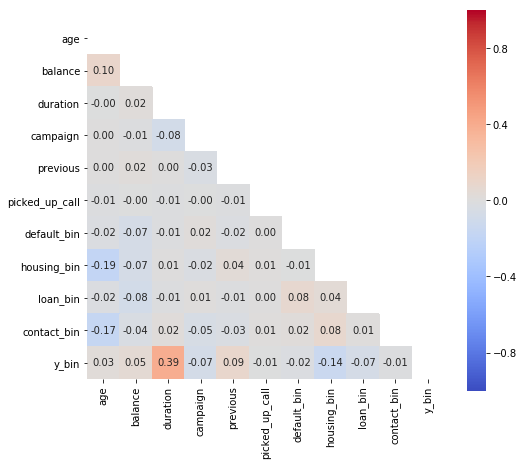

In [44]:
plt.figure(figsize=(8,7))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')


In [45]:
drop_columns_corr = [c for c in cols_corr_limp if (corr_matrix[c].abs() > 0.9).any()]
drop_columns_corr

[]

### 2 Estudio de outliers

Mostramos los graficos box-plot para un análisis gráfico de outliers

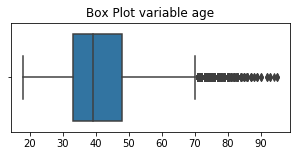

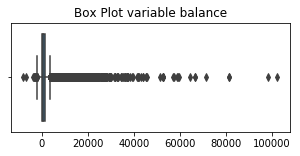

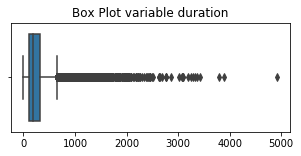

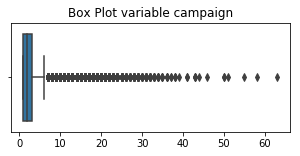

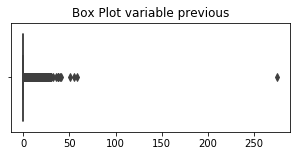

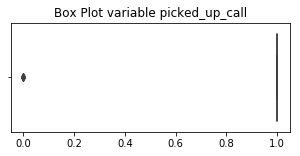

In [46]:
for c in quantitative_vars_limp:
  col_box = df_bank.select(c).toPandas()
  plt.figure(figsize=(5,2))
  plt.title('Box Plot variable ' + c)
  sns.boxplot(col_box, orient='h')
  

Añadimos para el análisis los gráficos de dispersión

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


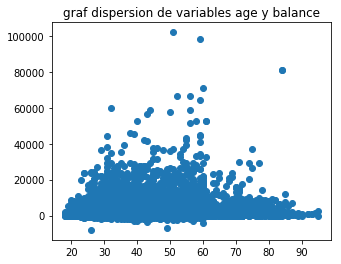

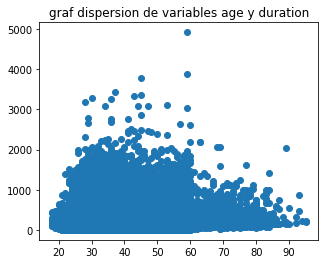

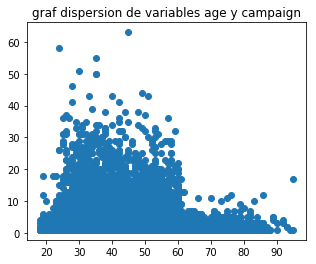

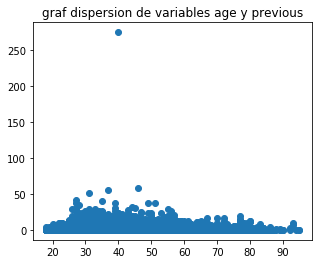

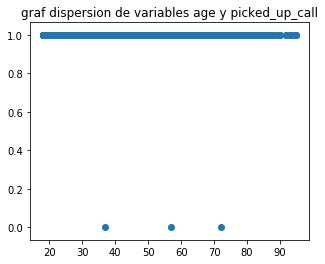

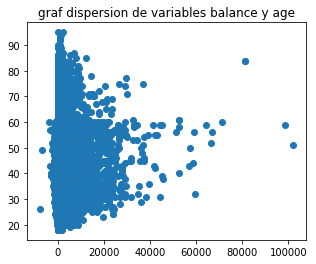

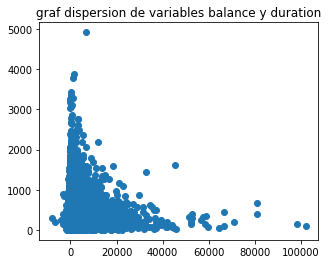

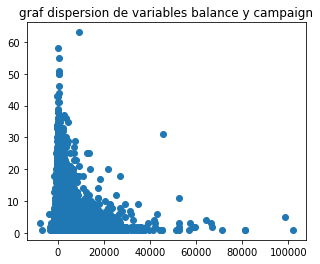

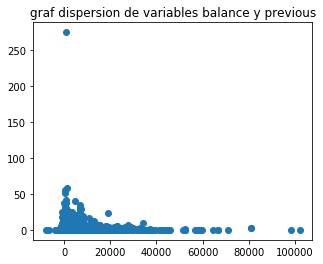

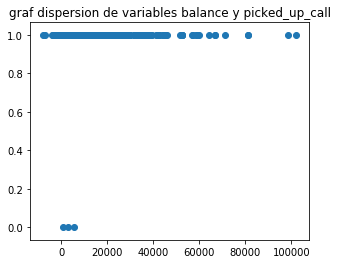

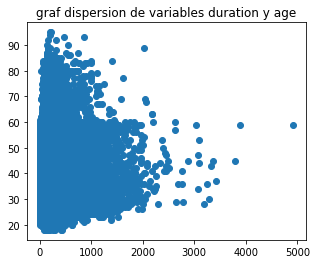

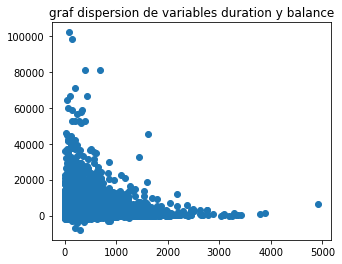

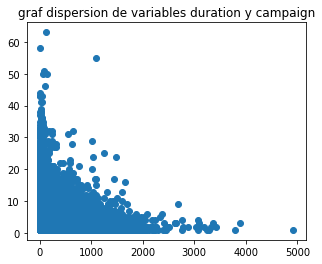

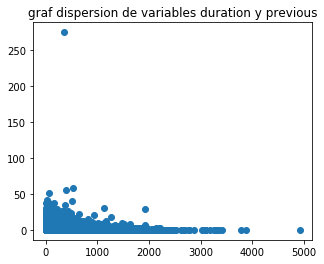

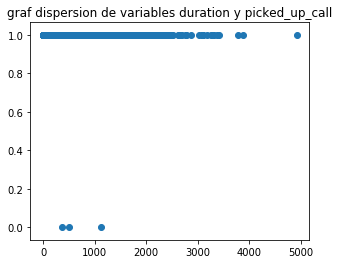

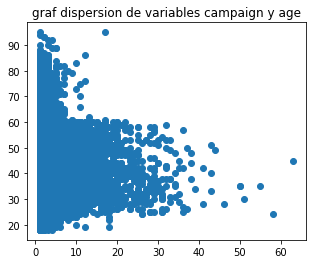

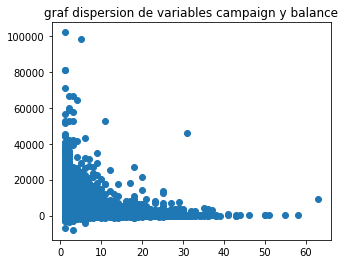

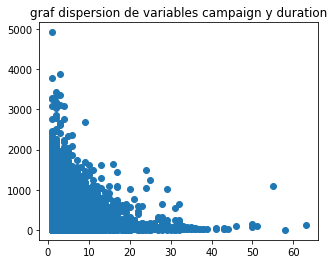

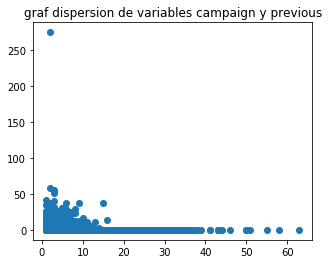

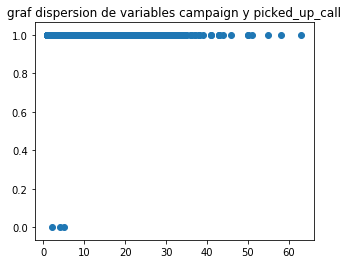

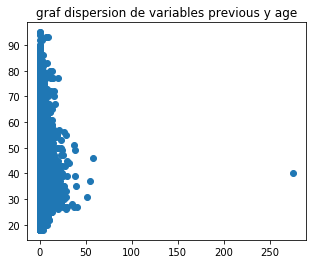

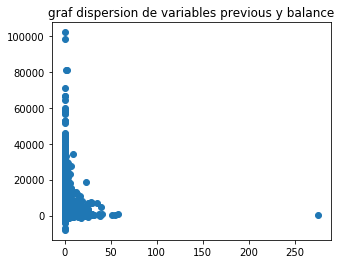

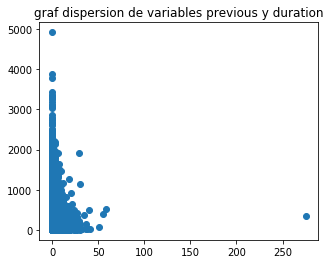

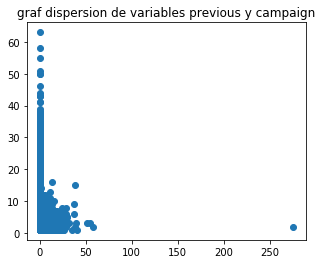

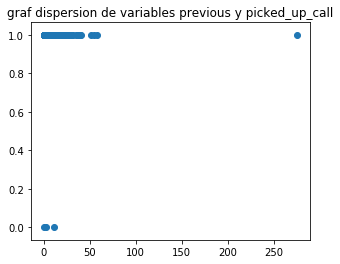

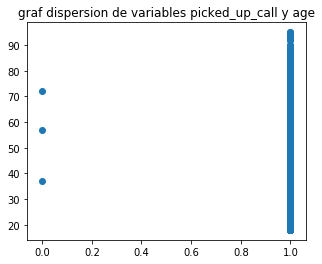

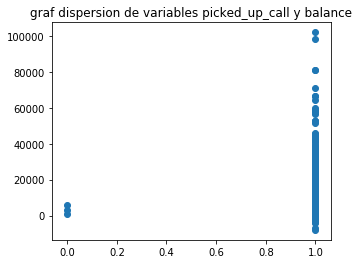

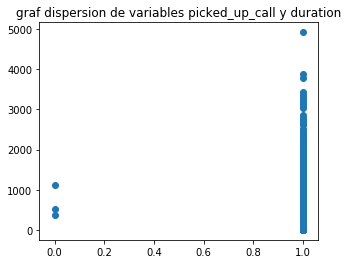

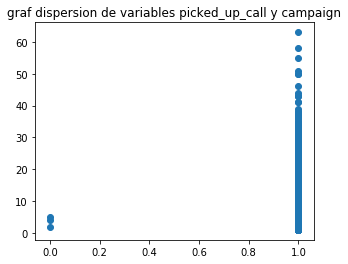

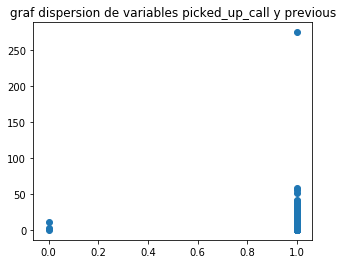

In [47]:
for c in quantitative_vars_limp:
  for d in quantitative_vars_limp:
    if c!=d:
      col_disp1 = df_bank.select(c).toPandas()
      col_disp2 = df_bank.select(d).toPandas()
      plt.figure(figsize=(5,4))
      plt.title('graf dispersion de variables ' + c + ' y ' + d )
      plt.scatter(col_disp1, col_disp2)


Como conclusión del análisis gráfico aplicaremos el test de Tukey de valores extremos a las variables *age*, *duration*, *campaign* y *previous*

In [0]:
#Funcion de test de Tukey
def remove_tukey_outliers(df, col):
  q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
  IQR = q3 - q1
  min_thresh = q1 - 3 * IQR
  max_thresh = q3 + 3 * IQR
   
  df_no_outliers = df.filter(F.col(col).between(min_thresh, max_thresh))
   
  return df_no_outliers

In [49]:
#Comprobamos dimensiones del df antes de aplicarlo
nrows= shape(df_bank)[0]
ncols= shape(df_bank)[1]
print('El dataframe tiene {} filas y {} columnas'.format(nrows,ncols))

El dataframe tiene 45211 filas y 22 columnas


In [0]:
col_outlier = ['age','duration','campaign','previous']
for column in col_outlier:
  df_bank = remove_tukey_outliers(df_bank,column)
 

In [51]:
#Comprobamos dimensiones del df después de aplicarlo
nrows= shape(df_bank)[0]
ncols= shape(df_bank)[1]
print('El dataframe tiene {} filas y {} columnas'.format(nrows,ncols))

El dataframe tiene 34544 filas y 22 columnas


Una vez eliminados los valores extremos (10667) volvemos a lanzar los gráficos Box-plot para ver si podemos dar por limpiada la base de datos

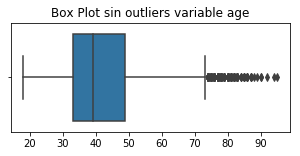

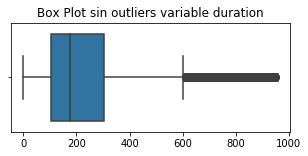

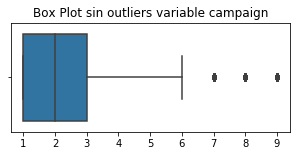

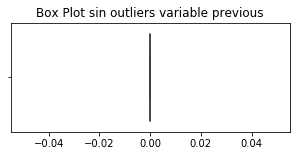

In [52]:
for c in col_outlier:
  col_box = df_bank.select(c).toPandas()
  plt.figure(figsize=(5,2))
  plt.title('Box Plot sin outliers variable ' + c)
  sns.boxplot(col_box, orient='h')
  

### 3) Generación  de variables nuevas 

In [0]:
df_bank=df_bank.withColumn('total_contact',(F.col('campaign') + F.col('previous')))

In [65]:
nrows= shape(df_bank)[0]
ncols= shape(df_bank)[1]
print('El dataframe tiene {} filas y {} columnas'.format(nrows,ncols))

El dataframe tiene 34544 filas y 23 columnas
